In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import astropy.utils.data
import scipy.optimize
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8., 8.]
matplotlib.rcParams['font.size'] = 16

## 4. Molecular Clouds

*Contributions from Rakshitha Thaman*

A number of radio surveys have cataloged the molecular clouds in our galaxy, one of which is SEDIGISM. Using the merged catalog of molecular clouds in that region, find the relation between a virial mass defined as $5\sigma^2 R/G$ and the integrated CO luminosity found in the catalogs (which is for $^{13}$CO).

In [2]:
sedigism_file = astropy.utils.data.download_file('https://sedigism.mpifr-bonn.mpg.de/CATS/SEDIGISM_catalogue_merged.fits')

In [3]:
sedigism = fitsio.read(sedigism_file)

The units of the radio observations are tricky. The "average integrated intensity" is given in K km s$^{-1}$, and is a specific intensity integrated over frequency. To get a flux requires multiplying back the solid angle in steradians:

In [4]:
ave_intensity = sedigism['ave_wco_K_kms'] # Average 13CO(2-1) integrated intensity in K km / s
flux = sedigism['area_as'] * (np.pi / 180./ 3600.)**2 * ave_intensity # now multiply by area

Meanwhile, a standard set of units for luminosity in this context is K km s$^{-1}$ pc$^2$. So we can multiply by the distance squared:

In [5]:
distance = sedigism['dist_kpc'] # Final adopted distance in kpc
L_CO = flux * 4. * np.pi * (distance*1e3)**2 # in K km/s pc^2

Then from the radius and the velocity dispersion measured from the line profile we can define the virial mass:

In [6]:
sigma = sedigism['sigv_kms'] # Velocity dispersion in km/s
radius = sedigism['radius_eq_pc'] # Equivalent radius estimated using the footprint area in pc
G = 6.67e-11 # m^3 kg^-1 s^-2
M_vir = 5. * (sigma * 1e3)**2 * (radius * 3.e16) / (G * 2.e30) # in M_sun

We can clean the data of some loose NaNs, and fit a power law to the virial mass as a function of luminosity of this transition.

In [7]:
ind_nan = np.isnan(np.log10(M_vir))
M_vir = np.delete(M_vir, ind_nan)
L_CO = np.delete(L_CO, ind_nan)

<ipython-input-7-48e6182510ac>:1: RuntimeWarning: invalid value encountered in log10
  ind_nan = np.isnan(np.log10(M_vir))


In [8]:
def func(x, m,c):
    return m*x+c

popt, pcov = scipy.optimize.curve_fit(func, np.log10(L_CO), np.log10(M_vir))

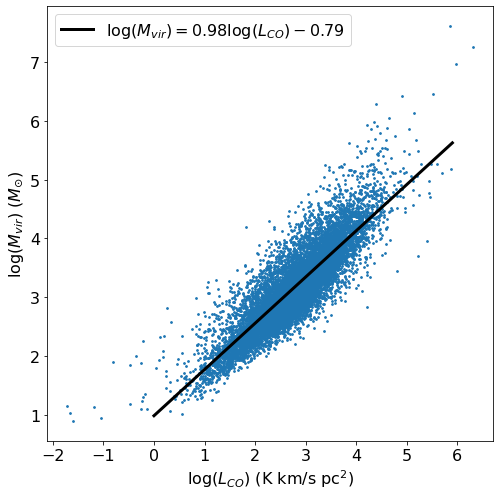

In [9]:
plt.scatter(np.log10(L_CO), np.log10(M_vir), s=3)
x = np.arange(0,6,0.1)
label = '$\log(M_{{vir}})={p1:.2f}\log(L_{{CO}}) - {p0:.2f}$'.format(p0=popt[0], p1=popt[1])
plt.plot(x, func(x, popt[0], popt[1]), label=label, color='black', linewidth=3)
plt.xlabel(r'$\log(L_{CO})$ (K km/s pc$^2$)')
plt.ylabel(r'$\log(M_{vir})\ (M_{\odot})$')
plt.legend()

We learn that the relation has quite a bit of scatter but is close to linear. This is part of the motivation that we can use the luminosity of CO to infer the total molecular gas mass. 

Note that we have used the apparently arbitrary choice of 5 for the virial coefficient. This is motivated by more detailed, though old, theoretical studies of the structure of molecular clouds (Bertoldi and McKee 1992).